# PRETRAIN FROM PERSONALLY TRAINED MODEL
## FastAI Cassava Root Disease Classification

In [1]:

## PREVIOUS BEST WITH ACC = 0.87
# RUN_NAME_OF_MODEL_TO_LOAD = '20210210-1221 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=40 bs=8 res=480'
# EPOCH_TO_LOAD = 1


In [2]:
RUN_NAME_OF_MODEL_TO_LOAD = '20210216-0426 - arch=densenetblur121d - samples=1800 frozen=1 epochs=60 bs=32 res=400'
RUN_NAME_OF_MODEL_TO_LOAD = '20210216-1811 - arch=densenetblur121d - samples=1800 frozen=1 epochs=60 bs=32 res=300'
RUN_NAME_OF_MODEL_TO_LOAD = '20210217-0055 - arch=densenetblur121d - samples=4000 frozen=1 epochs=60 bs=32 res=300'
RUN_NAME_OF_MODEL_TO_LOAD_last_last = '20210217-0231 - arch=densenetblur121d - samples=3000 frozen=1 epochs=60 bs=32 res=300'
RUN_NAME_OF_MODEL_TO_LOAD_last = '20210217-0525 - arch=densenetblur121d - samples=650 frozen=1 epochs=60 bs=32 res=300'
RUN_NAME_OF_MODEL_TO_LOAD = '20210217-1008 - arch=densenetblur121d - samples=650 frozen=1 epochs=60 bs=32 res=300'


# EPOCH_TO_LOAD = 9

<br>
<br>

In [5]:
from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from string import ascii_uppercase
import numpy as np
import operator
import glob

import torch
from torch import nn as nn
from torch.nn import functional as F

import gc
from cassava_utils import *
from pip_augs import *
from augmentation import *

%matplotlib inline

# %matplotlib widget

plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')


ARCH = 'densenetblur121d'  # resnet101

CHOSEN_SAMPLE_SIZE = 650 #1000  #1800  # use this to control per-category sample sizes # 1000  # deprecated but not removed
# TEST_SET_SIZE = round(CHOSEN_SAMPLE_SIZE * 0.1)  # number of images per category to put in the test set
FROZEN_EPOCHS = 1  # 1
EPOCHS = 60  # 4
BATCH_SIZE = 32  # 16
# RESOLUTION = round(380 * 1.2)  # 300
RESOLUTION=300
PRETRAINED_FLAG = True  # actually False - just to make sure we train a few times before attempting to find LR

# data = ''
# rn_addon = f'_data={data}'

time = datetime.today().strftime("%Y%m%d-%H%M")

# RUN_NAME = f'{time} - arch={ARCH.__name__} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'
RUN_NAME = f'{time} - arch={ARCH} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'

print(f"RUN_NAME = '{RUN_NAME}'")


RUN_NAME = '20210220-2133 - arch=densenetblur121d - samples=650 frozen=1 epochs=60 bs=32 res=300'


In [6]:
show_cuda_status()

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER

fastai version:              2.2.5
cuda version:                11.0
torch version:               1.7.0


<br>
<br>

### Check for Imbalance

In [9]:
classes = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

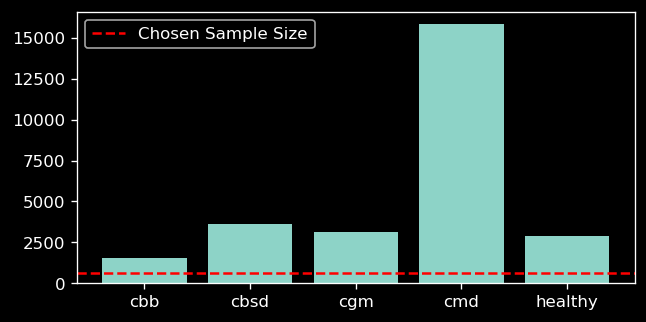

In [10]:
path = '../data/train_images_sorted_extra'

img_flist = {}
img_quants = {}
all_files = []

for c in classes:
    files = get_image_files(f'{path}/{c}')
    img_flist[c] = list(files)
    img_quants[c] = len(files)
    all_files.extend(files)

minqc = min(img_quants, key=img_quants.get)

sample_size = CHOSEN_SAMPLE_SIZE #round(img_quants[minqc] * 5)  # oversample the lowest class quantity


plt.figure(figsize=(6,3))
plt.bar(img_quants.keys(), img_quants.values())  
plt.axhline(sample_size, ls='--', color='red', label='Chosen Sample Size')
plt.legend()
plt.show()
        

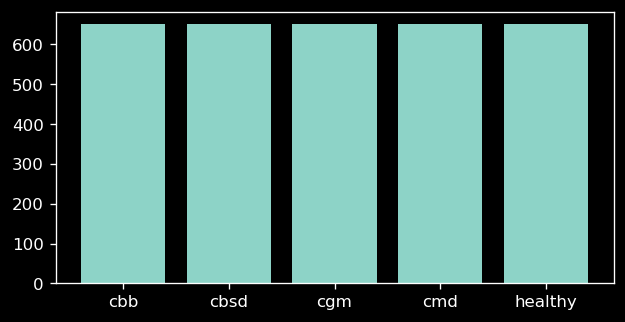

In [11]:

for c in classes:
    if len(img_flist[c]) < sample_size:
#         all_covid = img_flist[c].copy()
        img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], sample_size - len(img_flist[c]), replace=True))
    else:
        img_flist[c] = np.random.choice(img_flist[c], sample_size, replace=False)  # without replacement

    # boost the weak class
#     if c == 'healthy':
#         img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], round(sample_size * 0.5), replace=False))
    # hide the overeager class
#     if c == 'healthy':
#         img_flist[c] = np.random.choice(img_flist[c], round(sample_size * 0.95), replace=False)
        
    # increase data for augmentations   
#     img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], len(img_flist[c]), replace=False))  
plt.figure(figsize=(6,3))
plt.bar(img_flist.keys(), [len(l) for l in img_flist.values()])
plt.show()

In [12]:
test_flist = {}
test_size = round(0.1 * sample_size)

for c in classes:
    img_flist[c] = np.random.choice(img_flist[c], len(img_flist[c]), replace=False)  # shuffle
    test_flist[c] = img_flist[c][0:test_size]
    img_flist[c] = img_flist[c][test_size:]
#     img_flist[c] = [f for f in img_flist[c] if f not in test_flist[c]]

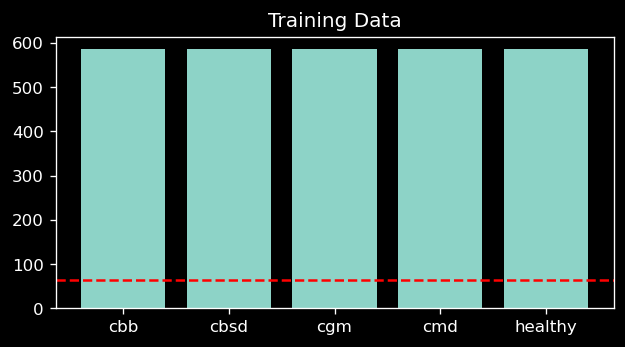

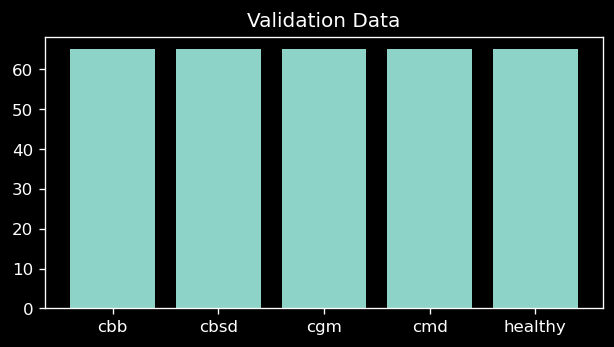

In [13]:
plt.figure(figsize=(6,3))
plt.title('Training Data')
plt.bar(img_flist.keys(), [len(l) for l in img_flist.values()])
plt.axhline(test_size, ls='--', color='red')
plt.show()

plt.figure(figsize=(6,3))
plt.title('Validation Data')
plt.bar(test_flist.keys(), [len(l) for l in test_flist.values()])
plt.show()
                 

<br>
<br>

### Create the DataLoaders

In [14]:
# with open(f"INACCFLIST_{RUN_NAME_OF_MODEL_TO_LOAD_last_last}.p", "rb") as pfile:
#     inacc_flist = pickle.load(pfile)

In [15]:
def get_fnames(path):
    retlist = []
    
    for l in img_flist.values():
        for f in l:
            retlist.append(f)
     
#     retlist = all_files # @TODO REMOVE ALL FILES
#     retlist.extend(np.random.choice(inacc_flist, 1000, replace=True))
#     retlist.extend(inacc_flist)  # @TODO REMOVE INACC CODE
            
    return random.sample(retlist, len(retlist))


item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())


batch_tfms = [Normalize.from_stats(*imagenet_stats)]


img_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.28, seed=42),
    get_y=parent_label,
    item_tfms=item_tfms , batch_tfms=batch_tfms)

dls = img_db.dataloaders(path, batch_size=BATCH_SIZE)

<br>

### Verify the Training and Validation Batches

In [22]:
print('examples from the training set')
dls.train.show_batch(max_n=8, nrows=2)

examples from the training set


RuntimeError: stack expects each tensor to be equal size, but got [3, 600, 800] at entry 0 and [3, 888, 500] at entry 1

In [23]:
print('\nexamples from the validation set')
dls.valid.show_batch(max_n=8, nrows=2)


examples from the validation set


RuntimeError: stack expects each tensor to be equal size, but got [3, 600, 800] at entry 0 and [3, 666, 500] at entry 4

<br>
<br>

## Create our Callbacks

In [ ]:
# Eary stopping callback
early_stop_cb = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0001, patience=5)

# Save the current model's weights every epoch
save_cb = SaveModelCallback(fname=RUN_NAME, with_opt=True)

# Reduce the Learning Rate if valid_loss flatlines
reduceLR_cb = ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, min_lr=1e-8, patience=1, factor=4, reset_on_fit=False)

# Mixup callback for regularization
# mixup_cb = MixUp(alpha=0.3)
mixup_cb = None

# Cutmix callback for regularization
cutmix_cb = CutMix()
# cutmix_cb = None

# Gradient Accumulation
# gradacc_cb =  GradientAccumulation(n_acc=16)
gradacc_cb =  GradientAccumulation(n_acc=128)


# List of callbacks to be used later
cbs = [save_cb, GradientClip, gradacc_cb, ShowGraphCallback()]  # , reduceLR_cb

if mixup_cb != None:
    cbs.insert(0, mixup_cb)
    
if cutmix_cb != None:
    cbs.insert(0, cutmix_cb)




print('\nAll Callbacks: ', cbs)

### Visualize the effect of CutMix


In [ ]:
if cutmix_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cutmix_cb.x,cutmix_cb.y), ctxs=axs.flatten())
    
else: print('\n CutMix was not selected.')

<br>

### Visualize the Effect of MixUp

MixUp creates a linear interpolation between the target data and another datapoint.  In images, it shows up as ghostly figures.  The technique has been shown to be a good to decrease the liklihood of overfitting.

In [ ]:
if mixup_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(mixup_cb.x,mixup_cb.y), ctxs=axs.flatten())

else: print('\n MixUp was not selected.')

In [ ]:
# learn = cnn_learner(dls, ARCH , 
#                     pretrained=PRETRAINED_FLAG, wd=1e-4, opt_func=ranger,
#                     loss_func=LabelSmoothingCrossEntropyFlat(), 
#                     cbs = cbs, metrics=[error_rate, accuracy])

# from wwf.vision.timm import *
import timm
learn = timm_learner(dls, 
                     ARCH,
                     opt_func=ranger,
                     loss_func=LabelSmoothingCrossEntropyFlat(),
                     cbs=cbs, 
                     pretrained=PRETRAINED_FLAG,
                     metrics = [accuracy])  #.to_fp16()



In [ ]:
learn = convert_MP_to_blurMP(learn, nn.MaxPool2d)  # doesn't exist!
learn.model = convert_act_cls(learn.model, nn.ReLU, MishAuto())  # very expensive so we only use it on the last layers
learn.model = convert_act_cls(learn.model, nn.SiLU, SwishAuto())  # replace with a lower memory version


# learn = learn.to_fp16()  # convert to 16bit

In [ ]:
display(learn.loss_func, learn.opt_func, learn.cbs) #, '-------------------------------------', learn.model)  # Checkpoint

In [ ]:
learn.model[1]

In [ ]:
# # RUN_NAME_OF_MODEL_TO_LOAD = '20210211-0115 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
# EPOCH_TO_LOAD = 7

load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}.pth', learn, opt=ranger, with_opt=True)



# <br>
<br>
<br>
<br>

# ------------------ RUN TO HERE -------------------

<br>
<br>
<br>

## Find a Good Learning Rate to Start With

In [ ]:
LR_DIV = 14e0  # Shift the lr_min left by this amount.  Adjust as necessary
lr_min = 0.002  # just a default

In [ ]:
# from apex.fp16_utils import convert_network
# learn.model = convert_network(learn.model, torch.float16)

In [ ]:
# learn = learn.to_fp16()

In [ ]:
if PRETRAINED_FLAG == True:
    learn.freeze()
    lr_min,lr_steep = learn.lr_find()
    plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
    plt.axvline(lr_min/LR_DIV, ls='--', color='yellow', label=f'lr_min / {LR_DIV}={round(lr_min/LR_DIV,6)}')
    plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
    plt.legend()
    plt.show()

    print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, (Mim/10)/{LR_DIV}: {lr_min/LR_DIV}")

<br>
<br>

# Pick a Good Initial Learning Rate

In [ ]:
# LR_CHOICE = lr_min/LR_DIV
# LR_CHOICE = lr_steep
LR_CHOICE = 9e-3
# LR_CHOICE = 2e-4
# LR_CHOICE = 7e-2
# LR_CHOICE=1e-3

<br>
<br>

<br>
<br>

# Training the Model

<br>

## Fit the last layers, unfreeze, fit the whole net, with a decent initial LR, all in one go.



In [ ]:
if PRETRAINED_FLAG:
    print(f'FROZEN_EPOCHS:  {FROZEN_EPOCHS}')
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE}\n\n')

In [ ]:
if PRETRAINED_FLAG:
    learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE, pct_start=0.99, wd=0.1, reset_opt=True)
#     fit_hump(learn, 1, lr_max=LR_CHOICE, reset_opt=True)
#     learn.fit_one_cycle(FROZEN_EPOCHS, slice(LR_CHOICE), wd=0.1)

    print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
    torch.cuda.reset_max_memory_allocated()

## Manually set up the unfrozen runs

In [247]:
learn.unfreeze()

/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


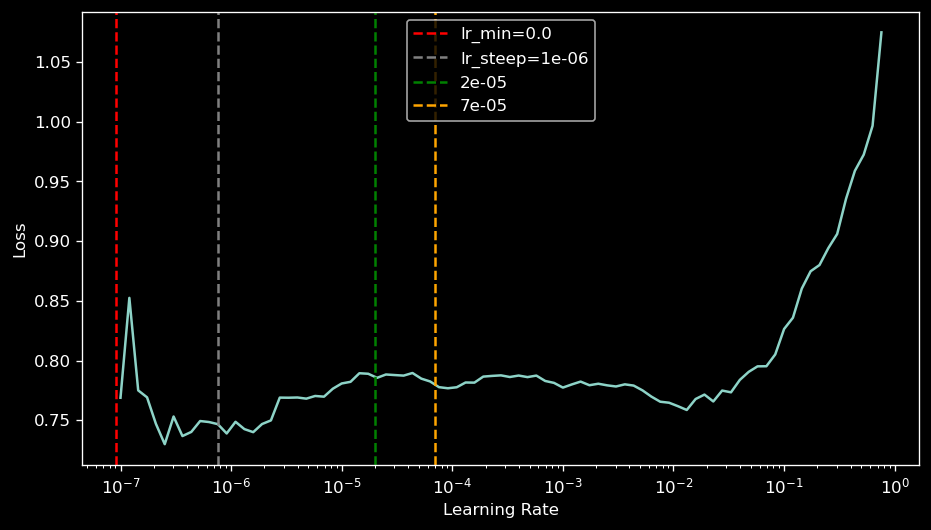

In [248]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()

In [27]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")  #, LR_CHOICE/2: {LR_CHOICE / 2}")

Minimum/10: 2.29e-07, steepest point: 7.59e-07


## Pick a new Learning Rate

In [280]:
# LR_CHOICE_UNFROZ = 9e-3
# LR_CHOICE_UNFROZ = 3e-3
# LR_CHOICE_UNFROZ = 4e-3
# LR_CHOICE_UNFROZ = 6e-3
# LR_CHOICE_UNFROZ = 5e-4
LR_CHOICE_UNFROZ = 5e-4



### Train

In [282]:
EPOCHS = 30

In [283]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

EPOCHS:         30
Learning Rate:  0.0005




/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Better model found at epoch 0 with valid_loss value: 0.776933491230011.


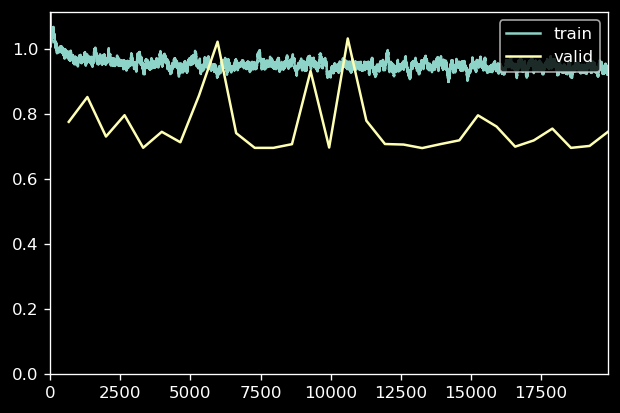

Better model found at epoch 2 with valid_loss value: 0.7317308783531189.
Better model found at epoch 4 with valid_loss value: 0.6971986889839172.
Better model found at epoch 10 with valid_loss value: 0.696875810623169.
Better model found at epoch 11 with valid_loss value: 0.6968549489974976.
Better model found at epoch 19 with valid_loss value: 0.6962302923202515.
Max GPU Memory Allocated: 3.625634816 GB


/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [284]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_one_cycle(EPOCHS, slice(LR_CHOICE_UNFROZ),  wd=1e-2)

learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.6, wd=1e-2, reset_opt=True)
# fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=True)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

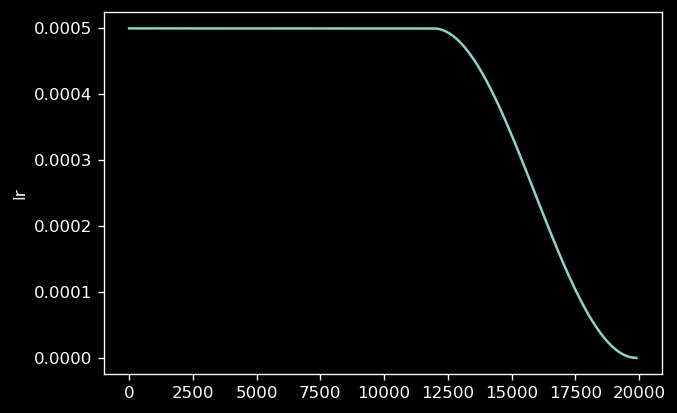

In [285]:
learn.recorder.plot_sched()

<br>
<br>

<br>

# -------------------- TRAIN AGAIN -----------------

<br>

<br>
<br>

### Train again

In [ ]:
# save_model("test.pth", learn, learn.opt, with_opt=True)

In [ ]:
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
#
    # RUN_NAME_OF_MODEL_TO_LOAD = '20210210-2234 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
    # EPOCH_TO_LOAD = 9

# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)

# load_model(f'models/{RUN_NAME}_8.pth', learn, opt=ranger, with_opt=True)
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
# load_model(f'test.pth', learn, opt=ranger, with_opt=True)

# load_model(f'models/20210213-2138 - arch=efficientnet_b3a - samples=1800 frozen=3 epochs=60 bs=32 res=400_9.pth', learn, opt=ranger, with_opt=True)

learn.dls = dls
learn.remove_cbs(cbs)
learn.add_cbs(cbs)

learn.opt.clear_state()


In [ ]:
learn.unfreeze()

In [ ]:
# learn.dls = dls_findlr
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()


learn.dls = dls
del dls_findlr
gc.collect()
torch.cuda.empty_cache()
gc.collect()


In [ ]:
EPOCHS = 20
LR_CHOICE_UNFROZ = 7e-3

In [ ]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

In [ ]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.2, wd=0.1) # , reset_opt=True)
fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=False)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Persist the Model

In [286]:
learn.export(f'../models/{RUN_NAME}.pkl')
print(f'Saved to: ../models/{RUN_NAME}.pkl')

# path = Path('../models')
# path.ls(file_exts='.pkl')

Saved to: ../models/20210217-1008 - arch=densenetblur121d - samples=650 frozen=1 epochs=60 bs=32 res=300.pkl


<br>
<br>

### Show some Results

/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


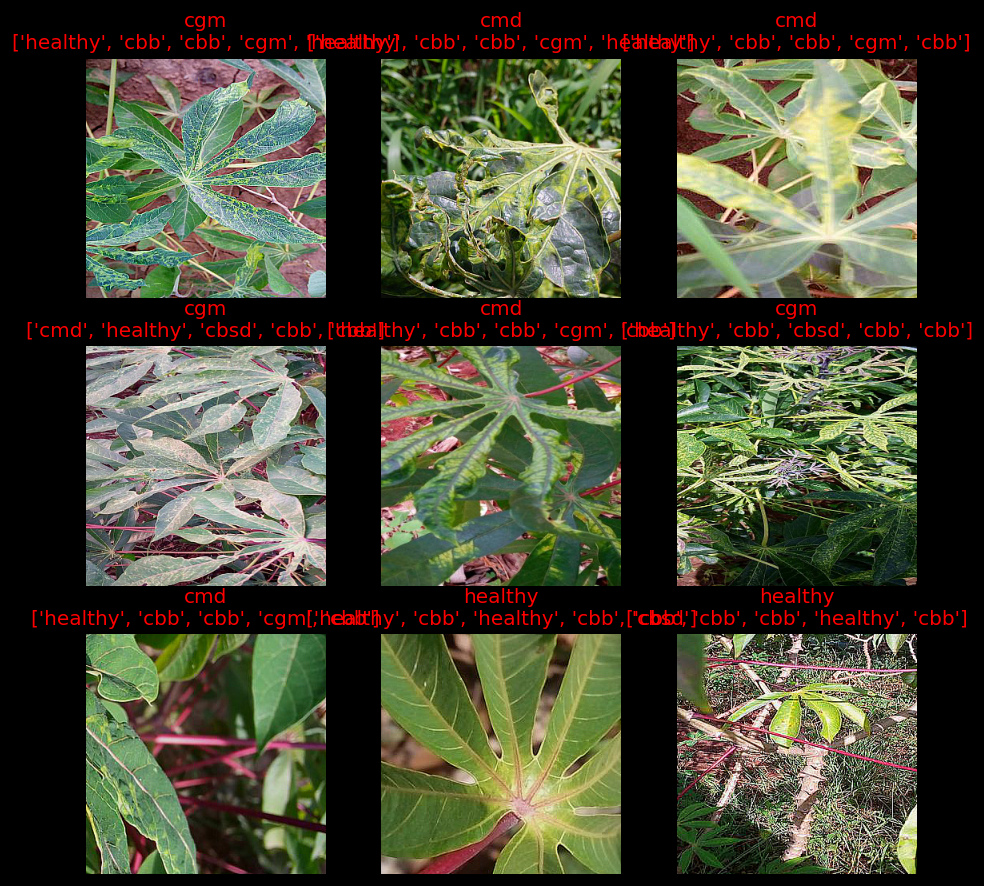

In [287]:
learn.show_results()


<br>
<hr>
<br>
<br>
<br>

# Validation Set (not test set) Analysis

<br>

### Plot Losses

In [ ]:
# learn.recorder.plot_loss()
# plt.ylabel('Loss')
# plt.xlabel('Batches Processed')

<br>

### Visualize with a confusion Matrix

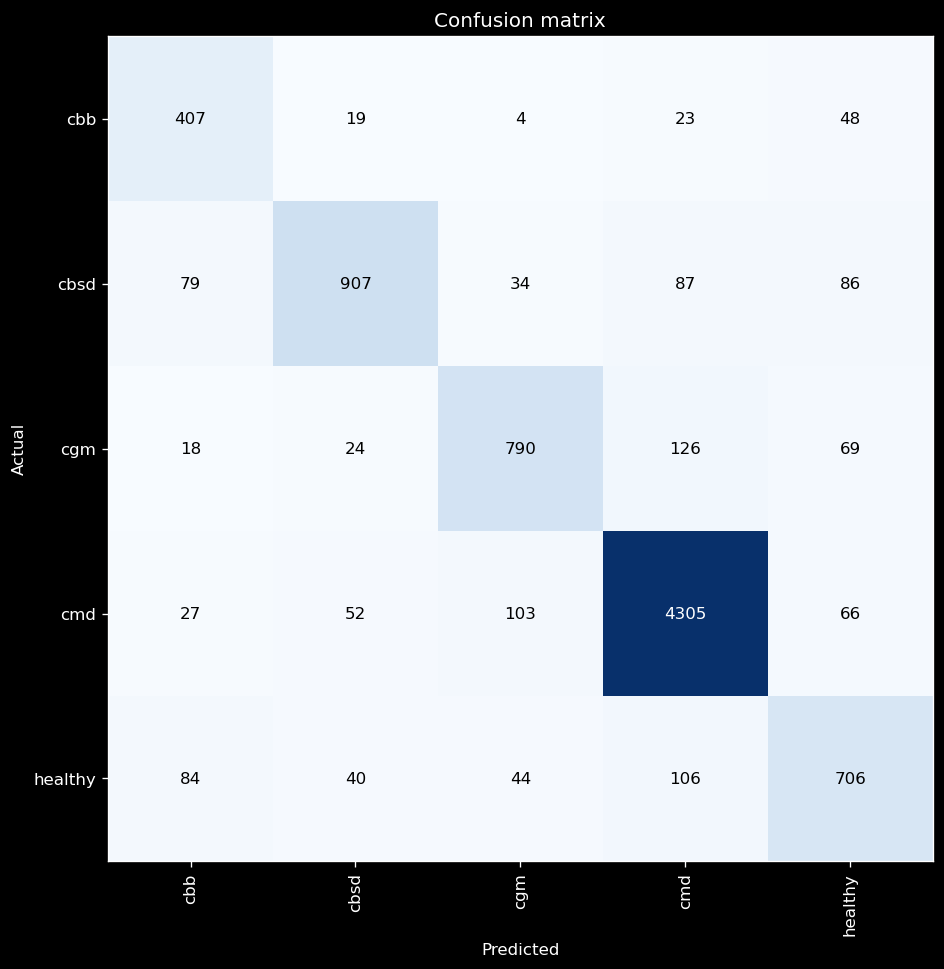

In [290]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [291]:
interp.most_confused()[:10]

[('cgm', 'cmd', 126),
 ('healthy', 'cmd', 106),
 ('cmd', 'cgm', 103),
 ('cbsd', 'cmd', 87),
 ('cbsd', 'healthy', 86),
 ('healthy', 'cbb', 84),
 ('cbsd', 'cbb', 79),
 ('cgm', 'healthy', 69),
 ('cmd', 'healthy', 66),
 ('cmd', 'cbsd', 52)]

<br>
<br>

## Classification Report

In [292]:
interp.print_classification_report()

              precision    recall  f1-score   support

         cbb       0.66      0.81      0.73       501
        cbsd       0.87      0.76      0.81      1193
         cgm       0.81      0.77      0.79      1027
         cmd       0.93      0.95      0.94      4553
     healthy       0.72      0.72      0.72       980

    accuracy                           0.86      8254
   macro avg       0.80      0.80      0.80      8254
weighted avg       0.86      0.86      0.86      8254



<br>

### Show the top 15 most error prone images

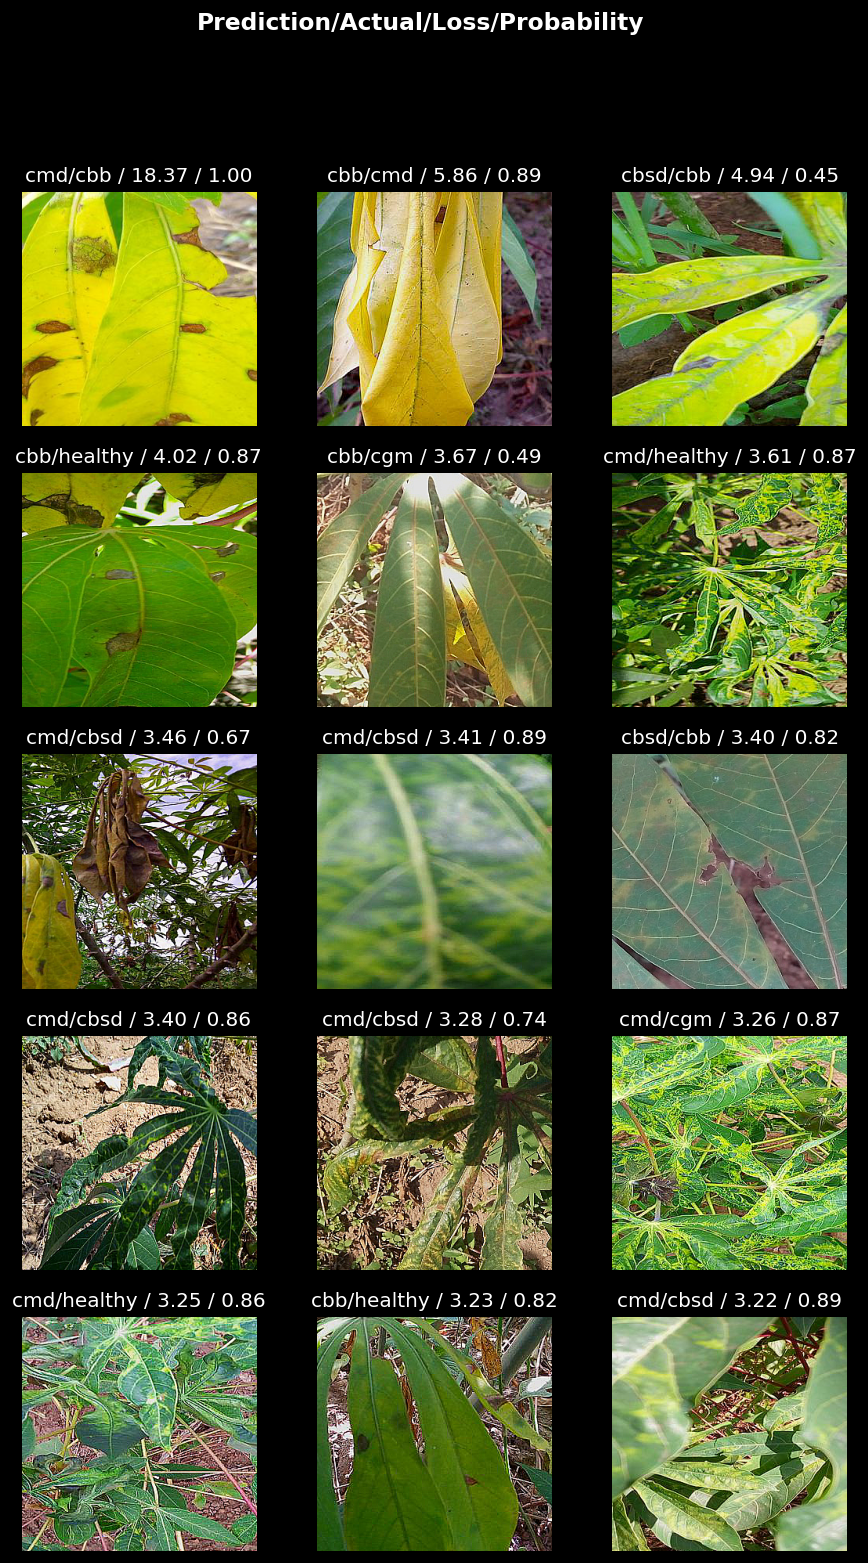

In [293]:
interp.plot_top_losses(15, nrows=5)

<br>
<br>
<br>
<br>

# ----------------- Validation ------------

<br>
<br>

<br>

In [294]:
VALID_RESOLUTION = 400
VALID_BATCH_SIZE = 12

test_learn = learn

# load_learner('../models/{RUN_NAME}.pkl', cpu=False)
# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}.pth', test_learn, opt=ranger, with_opt=True)


In [295]:
def get_train_aug_test(): return A.Compose([
            A.RandomResizedCrop(VALID_RESOLUTION,VALID_RESOLUTION, scale=(0.2, 1)),
            A.Transpose(p=0.7),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.7),
            A.HueSaturationValue(
                hue_shift_limit=0.3, 
                sat_shift_limit=0.3, 
                val_shift_limit=0.3, 
                p=0.7
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.2,0.2), 
                contrast_limit=(-0.2, 0.2), 
                p=0.7
            ),
            A.CoarseDropout(p=0.8, max_holes=20),
            A.Cutout(p=0.8, max_h_size=12, max_w_size=12),
            A.Sharpen(p=0.3, alpha=(0.1,0.3), lightness=(0.3, 0.9))
], p=1.0)



def get_valid_aug_test(): return A.Compose([
    A.Resize(VALID_RESOLUTION, VALID_RESOLUTION, p=1.0),
    A.OneOf([
        A.CenterCrop(VALID_RESOLUTION,VALID_RESOLUTION, always_apply=True),
        A.RandomResizedCrop(VALID_RESOLUTION,VALID_RESOLUTION, scale=(0.4, 0.7), always_apply=True),

        ], p=1.0),
        A.Resize(VALID_RESOLUTION, VALID_RESOLUTION, p=1.0),

            A.HorizontalFlip(p=0.5),

        A.HueSaturationValue(
            hue_shift_limit=0.14, 
            sat_shift_limit=0.14, 
            val_shift_limit=0.14, 
            p=0.5
            ),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.15,0.15), 
            contrast_limit=(-0.1, 0.2), 
            p=0.5
            ),
    A.Sharpen(p=1, alpha=(0.1, 0.3), lightness=(0.3, 0.9))
], p=1.0)

In [296]:
def get_test_fnames(path):
    retlist = []
    
    for l in test_flist.values():
        for f in l:
            retlist.append(f)
            
    return random.sample(retlist, len(retlist))


In [297]:


test_item_tfms = [AlbumentationsTransform(get_train_aug_test(), get_valid_aug_test())]





test_batch_tfms = [Normalize.from_stats(*imagenet_stats)]

test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=test_item_tfms,
    batch_tfms=test_batch_tfms)
#     item_tfms=Resize(VALID_RESOLUTION, method='bilinear', pad_mode='zeros'), 
#     batch_tfms=[Normalize.from_stats(*imagenet_stats)])  #batch_tfms) #,

dls = test_db.dataloaders(get_test_fnames, bs=VALID_BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

####  Get the Inferrences on the Test Set

In [298]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True, reorder=False)


/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [299]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

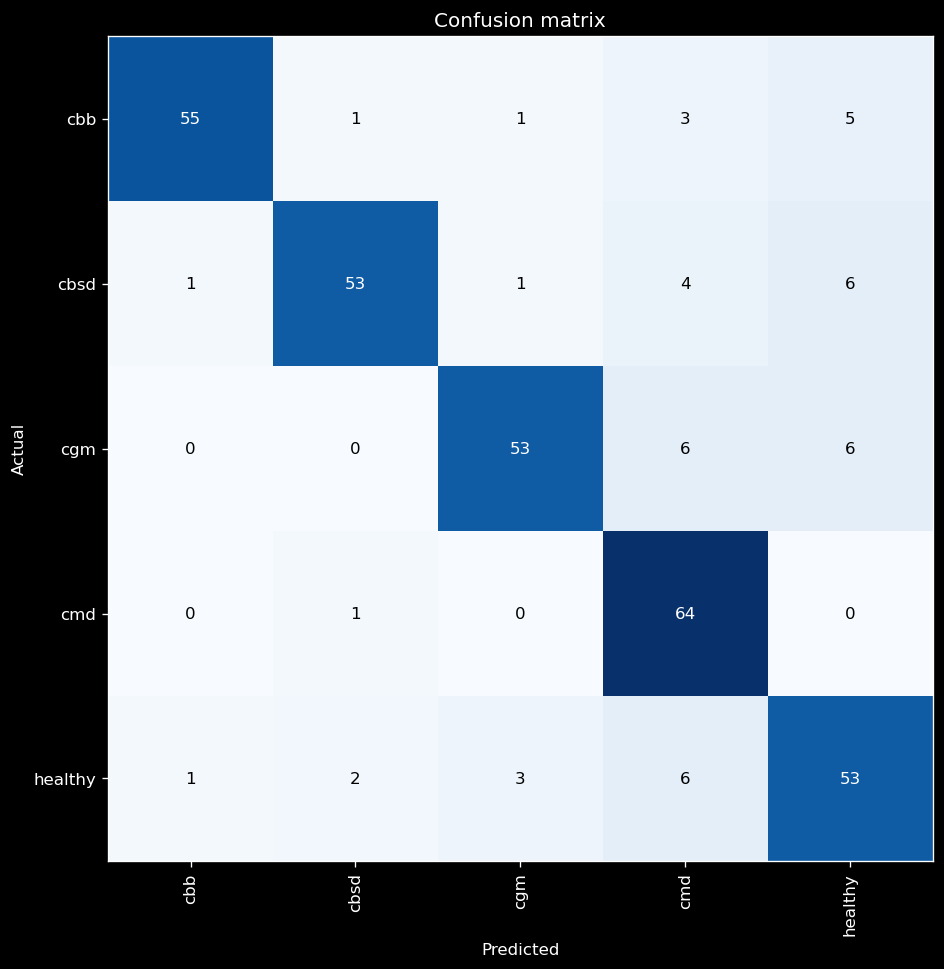

In [300]:
interp.plot_confusion_matrix(figsize=(8,8))

In [301]:
interp.most_confused()[:10]

[('cbsd', 'healthy', 6),
 ('cgm', 'cmd', 6),
 ('cgm', 'healthy', 6),
 ('healthy', 'cmd', 6),
 ('cbb', 'healthy', 5),
 ('cbsd', 'cmd', 4),
 ('cbb', 'cmd', 3),
 ('healthy', 'cgm', 3),
 ('healthy', 'cbsd', 2),
 ('cbb', 'cbsd', 1)]

<br>
<br>

## Classification Report

In [302]:
interp.print_classification_report()

              precision    recall  f1-score   support

         cbb       0.96      0.85      0.90        65
        cbsd       0.93      0.82      0.87        65
         cgm       0.91      0.82      0.86        65
         cmd       0.77      0.98      0.86        65
     healthy       0.76      0.82      0.79        65

    accuracy                           0.86       325
   macro avg       0.87      0.86      0.86       325
weighted avg       0.87      0.86      0.86       325



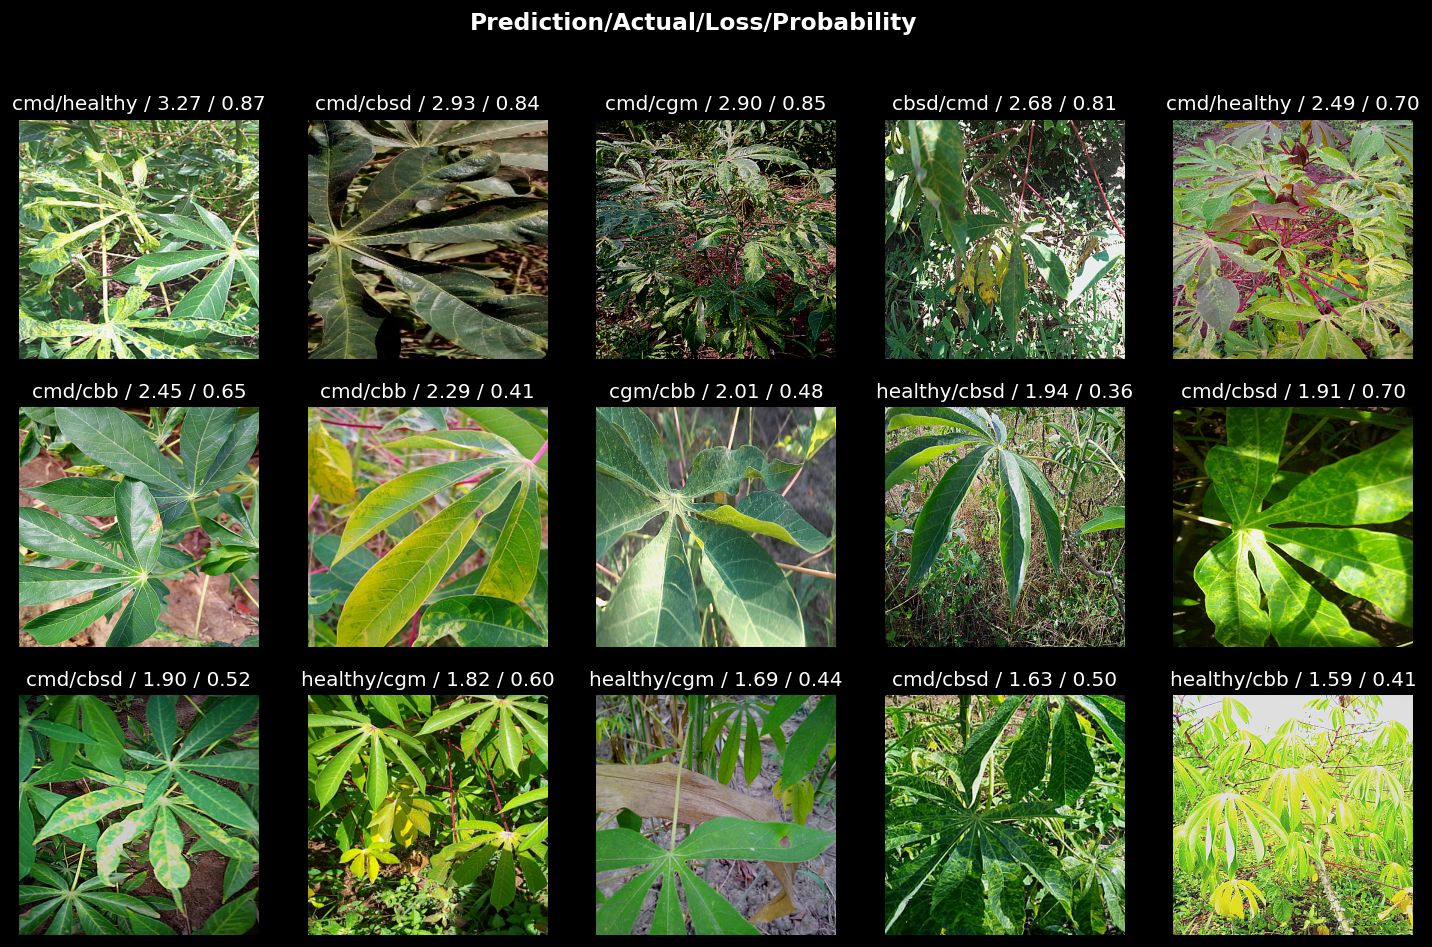

In [303]:
interp.plot_top_losses(k=15)

## Archive this version of the notebook

In [304]:
import os
import shutil

# Allow Jupyter the opportunity to autosave
!sleep 20
# time = '20210122-2356'
# copy the notebook file - the prefix links it to the saved model
shutil.copyfile('DenseNet Cassava Disease Classification.ipynb', f'.Archive/{time} - DenseNet Cassava Disease Classification.ipynb')

'.Archive/20210217-1008 - DenseNet Cassava Disease Classification.ipynb'

## Infer on the Kaggle provided test set

In [308]:
predstta, targstta = test_learn.tta(dl=test_dl, n=3)  #, use_max=False, beta=0.1)
# print(classification_report(sample_df.iloc[:,0], preds.argmax(dim=-1).numpy()))  # TTA

/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [309]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(predstta.argmax(dim=-1), targstta))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1961
           1       0.82      0.88      0.85      3939
           2       0.74      0.86      0.80      3322
           3       0.96      0.91      0.94     17056
           4       0.75      0.78      0.76      3204

    accuracy                           0.88     29482
   macro avg       0.81      0.84      0.83     29482
weighted avg       0.88      0.88      0.88     29482



# FIND ALL WRONG FILES

In [305]:
def get_test_fnames(path):
    return all_files

test_item_tfms = [AlbumentationsTransform(get_train_aug_test(), get_valid_aug_test())]
test_batch_tfms = [Normalize.from_stats(*imagenet_stats)]

test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=test_item_tfms,
    batch_tfms=test_batch_tfms)

dls = test_db.dataloaders(get_test_fnames, bs=VALID_BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

allpreds, alltargs, alldecoded = test_learn.get_preds(dl=test_dl, with_decoded=True)

/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [306]:
inacc_flist = []

for i in range(len(alltargs)):
    if int(alltargs[i]) != int(alldecoded[i]):
        inacc_flist.append(test_dl.items[i])
        
print(f'Number of inaccurate inferrences: {len(inacc_flist)}')
print(f'Percent Accurate:  {1 - (len(inacc_flist) / len(alltargs))}')

        

Number of inaccurate inferrences: 3771
Percent Accurate:  0.8720914456278407


In [307]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print(classification_report(alltargs, allpreds.argmax(dim=-1)))
# confusion_matrix(alltargs, allpreds.argmax(dim=-1))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1888
           1       0.87      0.81      0.84      4258
           2       0.83      0.75      0.79      3818
           3       0.91      0.96      0.94     16149
           4       0.76      0.74      0.75      3369

    accuracy                           0.87     29482
   macro avg       0.83      0.80      0.82     29482
weighted avg       0.87      0.87      0.87     29482



In [59]:
import pickle
with open(f"INACCFLIST_{RUN_NAME_OF_MODEL_TO_LOAD}.p", "wb") as pfile:
    pickle.dump(inacc_flist, pfile)

In [61]:
test_learn.predict('../data/test_images/2216849948.jpg')

/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


('cgm', tensor(2), tensor([0.0104, 0.0437, 0.5279, 0.0640, 0.3539]))